In [2]:
import os
from pm4py.objects.log.importer.xes import factory as xes_importer

In [3]:
log = xes_importer.import_log(os.path.join("files","input_data","patients.xes"))

In [15]:
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.algo.discovery.dfg import factory as dfg_factory
from pm4py.objects.conversion.dfg import factory as dfg_mining_factory

#net, initial_marking, final_marking = inductive_miner.apply(log)

#dfg = dfg_factory.apply(log)
dfg = dfg_factory.apply(log, variant="performance")

#net, initial_marking, final_marking = dfg_mining_factory.apply(dfg)

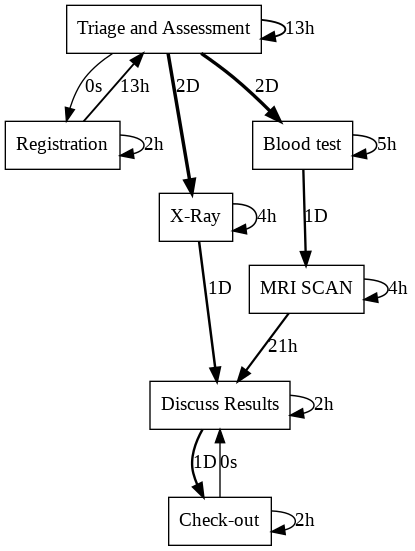

In [16]:
from pm4py.visualization.dfg import factory as dfg_vis_factory

gviz = dfg_vis_factory.apply(dfg, log=log, variant="performance")
dfg_vis_factory.view(gviz)

In [17]:
dfg

Counter({('Registration', 'Triage and Assessment'): 48525.78440366973,
         ('Triage and Assessment', 'Registration'): 0.0,
         ('Triage and Assessment', 'Blood test'): 181831.37974683545,
         ('Blood test', 'Blood test'): 19928.801687763713,
         ('Blood test', 'MRI SCAN'): 91451.63559322034,
         ('MRI SCAN', 'MRI SCAN'): 14939.169491525423,
         ('MRI SCAN', 'Discuss Results'): 76899.01694915254,
         ('Discuss Results', 'Discuss Results'): 10084.881720430107,
         ('Discuss Results', 'Check-out'): 94323.4699186992,
         ('Check-out', 'Check-out'): 7440.878048780488,
         ('Registration', 'Registration'): 10761.06647398844,
         ('Triage and Assessment', 'Triage and Assessment'): 47234.7485549133,
         ('Triage and Assessment', 'X-Ray'): 190396.71264367815,
         ('X-Ray', 'X-Ray'): 17445.724137931036,
         ('X-Ray', 'Discuss Results'): 103426.40926640926,
         ('Check-out', 'Discuss Results'): 0.0})

In [7]:
from pm4py.algo.filtering.log.start_activities import start_activities_filter
log_start = start_activities_filter.get_start_activities(log)
log_start

{'Registration': 500}

In [14]:
log[0]

{'attributes': {'concept:name': '1'}, 'events': [{'concept:name': 'Registration', 'org:resource': 'r1', 'concept:instance': '1', 'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2017, 1, 2, 11, 41, 53, tzinfo=datetime.timezone.utc), '.order': '1'}, '..', {'concept:name': 'Check-out', 'org:resource': 'r7', 'concept:instance': '2230', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(2017, 1, 9, 19, 45, 45, tzinfo=datetime.timezone.utc), '.order': '4951'}]}